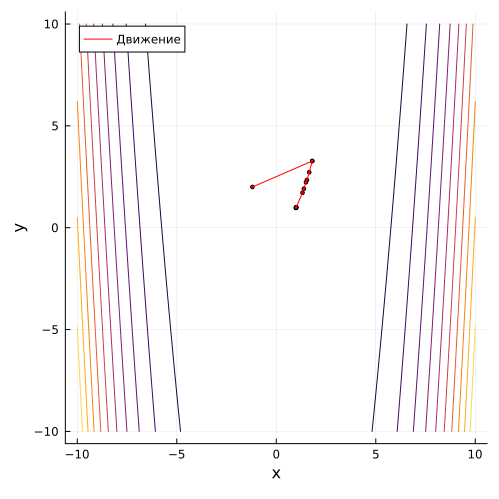

Точка минимума: [0.9999996871617004, 0.999999252428769], кол-во итераций: 12
Точка минимума: [0.9999999732176402, 0.999999907225889], кол-во итераций: 12


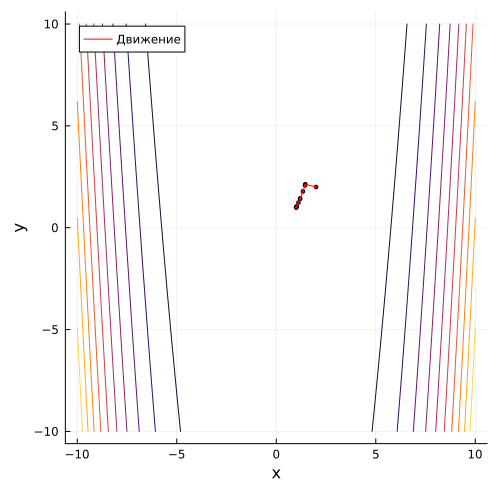

In [4]:
using LinearAlgebra
using Plots

function swann_method(f, x0, h=0.1)
    first = x0
    second = x0 + h
    # если функция растет, меняем направление движения
    if f(second) > f(first)
        h = -h
        first, second = second, second + h
    end
    last = second + h
    
    # увеличиваем шаг движения, если функция уменьшается
    while f(last) < f(second)
        h *= 2
        first, second, last = second, last, last + h
    end
    # перепрыгнули далеко
    if second > last
        first, second, last = last, second, first
    end

    return first, last
end

function df(f, x::Vector{Float64}, i, h=1e-5)
    x_plus = copy(x)
    x_minus = copy(x)
    
    x_plus[i] += h
    x_minus[i] -= h
    
    df_dx = (f(x_plus) - f(x_minus)) / (2h)
    
    return df_dx
end

function gradient(f, x::Vector{Float64})
    grad = []
    for i in 1:length(x)
        push!(grad, df(f, x, i))
    end
    return grad
end

function golden_section_search(f, a, b, eps=1e-5)
    phi = (sqrt(5) - 1) / 2 
    x1 = b - phi * (b - a)
    x2 = a + phi * (b - a)
    
    while abs(b - a) > eps
        if f(x1) <= f(x2)
            b = x2
        else
            a = x1
        end
        x1 = b - phi * (b - a)
        x2 = a + phi * (b - a)
    end
    
    return (a + b) / 2
end

function bfgs(f, start, epsilon)
    x = copy(start)
    points = [copy(x)]

    n = length(x)
    B = I(n)

    gradient = [df(f, x, j) for j in 1:n]
    i = 0

    while norm(gradient) > epsilon && i < max_iter
        s = -B * gradient

        g(alpha) = f(x + alpha * s)
        a, b = swann_method(g, 0.0)
        alpha = golden_section_search(g, a, b)

        x_new = x + alpha * s
        gradient_new = [df(f, x_new, j) for j in 1:n]

        y = gradient_new - gradient
        s = alpha * s

        rho = 1 / dot(y, s)
        B = (I - rho * s * y') * B * (I - rho * y * s') + rho * s * s'

        x = x_new
        gradient = gradient_new
        push!(points, copy(x))
        i += 1
    end
    return points, i
end

function davidon_fletcher_paull(f, x_start, learning_rate, eps)
    x = x_start
    trajectory = [x]
    gradient = [df(f, x, j) for j in 1:length(x)]
    H = [1 0; 0 1]
    prev_x = x
    prev_grad = gradient
    
    while norm(gradient) > eps
        s = H * gradient
        l, r = swann_method(alpha -> f(x - alpha * s), 1e-2)
        alpha = golden_section_search(alpha -> f(x - alpha * s),  l,  r)
        x_new = [x[1] - alpha * s[1], x[2] - alpha * s[2]]
        prev_x = x
        x = x_new
        push!(trajectory, x)
        
        prev_grad = gradient
        gradient = [df(f, x, j) for j in 1:length(x)]
        d_x = [x[1] - prev_x[1], x[2] - prev_x[2]]
        delta_g = [gradient[1] - prev_grad[1], gradient[2] - prev_grad[2]]
        A = (d_x * transpose(d_x)) / dot(transpose(d_x), delta_g)
        B = (H * (delta_g * transpose(delta_g)) * transpose(H)) / dot(transpose(delta_g), H * delta_g)
        H = H + A - B
    end
    
    return trajectory
end

function quadratic(x; a=1.0, b=2.0)
    return a * (x[1])^2 + b * (x[2])^2
end

function rosenbrock(x)
    return (1 - x[1])^2 + 100 * (x[2] - x[1]^2)^2
end

function schwefel(x)
    return 418.9829 * 2 - (x[1] * sin(sqrt(abs(x[1]))) + x[2] * sin(sqrt(abs(x[2]))))
end

function rastrigin(x)
    return 20 + sum(x.^2 .- 10 * cos.(2 * π * x))
end

max_iter = 100
d(x) = (1 - x[1])^2 + 100 * (x[2] - x[1]^2)^2
start = [-1.2, 2.0]
epsilon = 1e-4

points, i = bfgs(d, start, epsilon)
x_min = points[end]

x = -10:0.1:10
y = -10:0.1:10
x_coords = [point[1] for point in points]
y_coords = [point[2] for point in points]
contour(x, y, (x, y) -> d([x, y]), levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")
p = plot!(x_coords, y_coords, label="Движение", line=:red)
println("Точка минимума: $x_min, кол-во итераций: $i")
display(p)

init = [2.0, 2.0]
points = davidon_fletcher_paull(d, init, 0.01, 0.001)
x_min = points[end]
x_coords = [point[1] for point in points]
y_coords = [point[2] for point in points]
contour(x, y, (x, y) -> d([x, y]), levels = 10, xlabel="x", ylabel="y", colorbar=false, size=(500, 500))
scatter!(x_coords, y_coords, markersize=2, markershape=:circle, markercolor=:red, label = "")
p = plot!(x_coords, y_coords, label="Движение", line=:red)
println("Точка минимума: $x_min, кол-во итераций: $(length(points))")
display(p)